<a href="https://colab.research.google.com/github/WoodenPlancks/csc2611/blob/main/CSC2611_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Michal Fishkin
The GitHub link for this assignment can be found here:
https://github.com/WoodenPlancks/csc2611/tree/main.

# 0. Setup

Here I set up the directories to work for my Google Drive/Colab Setup and import necessary packages.

In [1]:
import gensim
from gensim.models import KeyedVectors

import pandas as pd
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt

import numpy as np
from numpy import dot
from numpy import mean
from numpy.linalg import norm

import scipy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

In [2]:
# Google Drive Directory
GDD = "/content/drive/MyDrive/Main/Masters/CSC2611 Semantic Change/Assignment/"

In [3]:
# Get the word2vec file.
EMBEDDING_FILE = 'GoogleNews-vectors-negative300.bin.gz'
model = KeyedVectors.load_word2vec_format(GDD+EMBEDDING_FILE, binary=True)

# **1. Synchronic Word Embedding** [7 points]

## **Step 3** [2 points]

Calculate cosine distance between each pair of word embeddings you have extracted,
and report the Pearson correlation between word2vec-based and human similarities.

In [4]:
# Load in the word pairs and their judged synonymy from Table 1.
table_data = pd.read_csv(GDD + "Table1.csv")

# Get the Word2Vec cosine similarities between each word pair.
table_data["Word2Vec Cosine Similarity"] = table_data.apply(
      lambda row: model.similarity(row["Word 1"], row["Word 2"]), axis=1)

# Get the correlation between the cosine similarities and the judged synonymy.
table_data["Word2Vec Cosine Similarity"].corr(table_data["Judged Synonymy"])

0.7601649411932078

Comment on this value in comparison to those from LSA and word-context vectors from analyses in the earlier exercise.

The exercise (300-dim PPMI Matrix Reduction) correlation value was around 0.350, which makes word2vec much stronger. I believe the larger context window and optimization between words that appear in the same context window better captures similarities.

## **Step 4** [3 points]
Perform the analogy test based on data here (or as provided) with the pre-trained
word2vec embeddings. Report the accuracy on the semantic analogy test and the syntactic
analogy test.

In [5]:
valid_analogies = pd.read_csv(GDD + "valid_analogies.csv")
valid_analogies_subset = valid_analogies.sample(300, random_state = 42)

In [6]:
### For the analogy [(x:y)::(a:b)]
# model.most_similar(positive=[y, a], negative=[x])[0]
# >>> b
### Example: man : king :: woman : ?
# model.most_similar(negative=['man'], positive=['king', 'woman'])[0]
# >> ('queen', 0.7118193507194519)

valid_analogies_subset["W2V Analogy Test Results"] = valid_analogies_subset.apply(lambda row:
            model.most_similar(
            negative=[row["A1"]],
            positive=[row["A2"], row["A3"]])[0],
            axis = 1)

valid_analogies_subset["Analogy Prediction Correct?"] = valid_analogies_subset.apply(
    lambda row:
    int(row["A4"] == row["W2V Analogy Test Results"][0]),
    axis = 1
)

valid_analogies_subset["Analogy Prediction Correct?"].mean()

0.65

Repeat the analysis with LSA vectors (300 dimensions) from the earlier exercise, and commment on the results in comparison to those from
word2vec.

***The LSA vectors completed 0 of the analogies correctly.*** Word2Vec seems to encode semantic and syntactic relationships much better than our bigram count-based methods can. I assume the somewhat regular English patterns for things like verb conjugations are better captured when the word is optimized to produce its context. For example, if a word is 'queen', female signifiers such as 'her' (e.g. in the phrase 'her crown') could appear in a context window in manners similar the male signifiers around the word 'king'. Clustering together queen and female signifiers would cluster in turn queen and woman, and the same analogy holds for king and man.

In [7]:
valid_analogies_subset.groupby(["Superfamily"]).agg('mean')["Analogy Prediction Correct?"]

<ipython-input-7-75862344d4eb>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  valid_analogies_subset.groupby(["Superfamily"]).agg('mean')["Analogy Prediction Correct?"]


Superfamily
semantic     0.750000
syntactic    0.642857
Name: Analogy Prediction Correct?, dtype: float64

My hypothesis is supported when we look at the analogy category breakdowns, shown below. Word2Vec does exceedingly well on syntactic tasks with some degree of regularity (e.g. comparatives, plurals), but does poorly on syntactic tasks with low regularity (e.g. opposite, adjective-to-verb).

In [8]:
valid_analogies_subset.groupby(["Superfamily", "Family"]).agg('mean')["Analogy Prediction Correct?"].sort_values(ascending = False)

<ipython-input-8-833491df26cc>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  valid_analogies_subset.groupby(["Superfamily", "Family"]).agg('mean')["Analogy Prediction Correct?"].sort_values(ascending = False)


Superfamily  Family                     
syntactic    gram6-nationality-adjective    1.000000
             gram3-comparative              0.807692
             gram7-past-tense               0.781609
             gram8-plural                   0.780488
semantic     city-in-state                  0.777778
syntactic    gram5-present-participle       0.774194
semantic     family                         0.727273
syntactic    gram9-plural-verbs             0.684211
             gram4-superlative              0.500000
             gram2-opposite                 0.250000
             gram1-adjective-to-adverb      0.242424
Name: Analogy Prediction Correct?, dtype: float64

## **Step 5** [2 points]
Suggest a way to improve the existing set of vector-based models in capturing word
similarities in general, and provide justifications for your suggestion.

To improve similarity scores for the vector-based models we investigated in the exercise, one way to potentially improve similarity metrics is to use a larger context window. In the exercise, we used only bigrams to construct the probability distributions. Using a larger context window would allow stronger correlations between words that do not appear right next to each other, which could allow for more nuanced word relations and potentially better similarities.

# **2. Diachronic Word Embedding** [8 points]

## **Step 1**
Download the diachronic word2vec embeddings from the course syllabus page. These
embeddings capture historical usage of a small subset of English words over the past century.

In [9]:
! unzip "/content/drive/MyDrive/Main/Masters/CSC2611 Semantic Change/Assignment/embeddings.zip" -d "/content/drive/MyDrive/Main/Masters/CSC2611 Semantic Change/Assignment/"

Archive:  /content/drive/MyDrive/Main/Masters/CSC2611 Semantic Change/Assignment/embeddings.zip
replace /content/drive/MyDrive/Main/Masters/CSC2611 Semantic Change/Assignment/embeddings/data.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/drive/MyDrive/Main/Masters/CSC2611 Semantic Change/Assignment/embeddings/data.pkl  
  inflating: /content/drive/MyDrive/Main/Masters/CSC2611 Semantic Change/Assignment/__MACOSX/embeddings/._data.pkl  
  inflating: /content/drive/MyDrive/Main/Masters/CSC2611 Semantic Change/Assignment/embeddings/readme.txt  
  inflating: /content/drive/MyDrive/Main/Masters/CSC2611 Semantic Change/Assignment/__MACOSX/embeddings/._readme.txt  
  inflating: /content/drive/MyDrive/Main/Masters/CSC2611 Semantic Change/Assignment/__MACOSX/._embeddings  


In [10]:
with open(GDD + 'embeddings/data.pkl', 'rb') as f:
    diachronic_embeddings = pickle.load(f)

The file data.pkl uses a subset of data from https://nlp.stanford.edu/projects/histwords/
The file is a dictionary that contains the following entries:
* 'w': a list of 2000 words, a subset of the English lexicon
* 'd': a list of decades between 1900 and 2000
* 'E': a 2000 by 10 by 300 list of list of vectors; the (i,j)-th entry is a 300-dimensional vector for the i-th word in the j-th decade

**Reference:**
*Hamilton, W. L., Leskovec, J., & Jurafsky, D. (2016). Diachronic word embeddings reveal statistical laws of semantic change. In Proceedings of the 54th annual meeting of the association for computational linguistics (volume 1:Long papers)(pp. 1489–1501).*


In [11]:
# Making the dictionary into a dataframe is more intuitive to me.

words = []
decades = []
embeddings = []


for word_ind in range(len(diachronic_embeddings['w'])):
    for decade_ind in range(len(diachronic_embeddings['E'][word_ind])):
        emb = diachronic_embeddings['E'][word_ind][decade_ind]
        if len([e for e in emb if e != 0]) == 0:
            continue

        words.append(diachronic_embeddings['w'][word_ind])
        decades.append(diachronic_embeddings['d'][decade_ind])
        embeddings.append(emb)

diachronic_df = pd.DataFrame(list(zip(words, decades, embeddings)),
    columns = ["Word", "Year", "Embedding"])

## **Step 2** [3 points]
Propose three different methods for measuring degree of semantic change for individual words and report the top 20 most and least changing words in table(s) from each
measure.



1. **1900 and 1990 embedding cosine distance**
 - The distance between a word's embedding in the first decade and the last will give a general idea of the dissimilarity of the word's semantic.
2. **Percent of shared neighbours between 1900 and 1990 embeddings**
 - Shared neighbours give insight into not only whether but how a word's semantics changed over time.
3. **Average movement year-to-year**
 - Taking the first and last years only for embedding comparisons can discount semantic changes that reversed at some point in the hundred years. Taking an average of the year-to-year movement could give better insight into the path of a word through the semantic space.
4. For curiosity: **1900 and 1990 embedding Euclidean distance**
  - Euclidean distance may capture the frequency effects that are useful in understanding semantic change over time.





Measure the intercorrelations (of semantic change in all words, given the embeddings from Step 1) among the three methods you have proposed and summarize the Pearson
correlations in a 3-by-3 table.

In [12]:
def cosine_sim(first_vec, last_vec, eps = 0.00001):
    return dot(first_vec, last_vec)/(norm(first_vec)*norm(last_vec) + eps)

In [13]:
method_1_df = pd.DataFrame(columns = ["Word", "Cosine Distance"])

for word in set(words):
    word_set = diachronic_df[diachronic_df["Word"] == word]
    first_vec = word_set.iloc[0]["Embedding"]
    last_vec = word_set.iloc[-1]["Embedding"]
    cos_dist = 1 - cosine_sim(first_vec, last_vec)
    method_1_df.loc[len(method_1_df.index)] = [word, cos_dist]

method_1_df.sort_values(by=['Cosine Distance'], ascending = False).head(20)

,Word,Cosine Distance
758,programs,0.990806
50,objectives,0.977793
713,computer,0.961241
1103,radio,0.905271
1458,sector,0.900685
24,goals,0.845149
1123,approach,0.839862
1030,van,0.836750
963,shri,0.824434
90,media,0.812537


In [14]:
df_by_year = {}

for year in set(decades):
    df = diachronic_df[diachronic_df["Year"] == year].copy()
    column_names = [str(i) for i in range(300)]
    decade_df = pd.DataFrame(columns = column_names, index = list(set(words)))
    for i, row in df.iterrows():
        decade_df.loc[row["Word"]] = row["Embedding"]
    df_by_year[year] = decade_df

In [15]:
def nearest_neighbours(year, word, n=20):

    df = df_by_year[year].copy()
    word_vector = df.loc[word]

    df["Cossim with " + word] = df.apply(lambda row:
             cosine_sim(row, word_vector),
             axis = 1)
    df.sort_values("Cossim with " + word, inplace=True, ascending = False)

    nns = set(df.index[1:n + 1])
    return nns

In [16]:
method_2_df = pd.DataFrame(columns = ["Word", "1900 NNs", "1990 NNs", "% Shared Neighbours"])

for word in tqdm(set(words)):
    word_set = diachronic_df[diachronic_df["Word"] == word]
    first_year = word_set.iloc[0]["Year"]
    last_year = word_set.iloc[-1]["Year"]
    if first_year == last_year:
        continue
    first_vec_nns = nearest_neighbours(first_year, word)
    last_vec_nns = nearest_neighbours(last_year, word)

    shared_neighbours = len(first_vec_nns.intersection(last_vec_nns))
    total_neighbours = len(first_vec_nns.union(last_vec_nns))

    percent_sn = shared_neighbours/total_neighbours

    method_2_df.loc[len(method_2_df.index)] = [word, first_vec_nns, last_vec_nns, percent_sn]

100%|██████████| 2000/2000 [20:35<00:00,  1.62it/s]


In [17]:
method_2_df.sort_values(by=['% Shared Neighbours'], ascending = True).head(20)

,Word,1900 NNs,1990 NNs,% Shared Neighbours
1103,radio,"{correlation, interaction, fluid, atoms, activ...","{media, frequency, electricity, interference, ...",0.000000
1890,impact,"{pressure, beam, motion, particles, rays, ions...","{significance, factors, economy, policy, contr...",0.000000
1780,assessment,"{payment, rates, assets, amount, damages, budg...","{planning, methods, diagnosis, management, rev...",0.000000
50,objectives,"{layer, electricity, material, tube, plate, at...","{chapter, plans, projects, policy, success, pr...",0.000000
713,computer,"{joseph, shri, thomas, iowa, robert, richard, ...","{device, instruction, mathematics, science, sy...",0.000000
1123,approach,"{certainty, surprise, sight, camp, advance, ar...","{technique, model, methods, attempt, design, t...",0.000000
1458,sector,"{r, circle, p, areas, k, management, axis, fig...","{manufacturing, market, economy, loans, invest...",0.000000
241,disposition,"{behavior, tendency, behaviour, wishes, charac...","{disposal, assets, lands, mankind, qualities, ...",0.025641
1782,signal,"{blow, success, victory, commander, signs, mar...","{phase, device, frequency, radio, circuit, vol...",0.025641
916,representation,"{legislature, parliament, sovereignty, idea, r...","{model, elections, form, speech, diagram, desc...",0.025641


In [18]:
method_1_df.sort_values(by=['Cosine Distance'], ascending = False).to_csv("sorted_m1_results.csv")
method_2_df.sort_values(by=['% Shared Neighbours'], ascending = True).to_csv("sorted_m2_results.csv")

In [19]:
method_4_df = pd.DataFrame(columns = ["Word", "Avg Movement"])

for word in set(words):

    word_set = diachronic_df[diachronic_df["Word"] == word]
    # print(word_set)
    delta_cos_dist = []
    for i in range(len(word_set) - 1):
        curr_vec = word_set.iloc[i]["Embedding"]
        next_vec = word_set.iloc[i + 1]["Embedding"]

        curr_year = word_set.iloc[i]["Year"]
        next_year = word_set.iloc[i + 1]["Year"]

        delta_t = next_year - curr_year
        delta_d = 1 - cosine_sim(curr_vec, next_vec)

        delta_cos_dist.append(delta_d/(delta_t/10))
        # print(delta_cos_dist)

    method_4_df.loc[len(method_4_df.index)] = [word, mean(delta_cos_dist)]

method_4_df.sort_values(by=['Avg Movement'], ascending = False).head(20)

,Word,Avg Movement
1818,harper,0.421870
1940,jones,0.421552
1458,sector,0.408143
942,berkeley,0.402432
416,wiley,0.401816
563,baltimore,0.399487
52,martin,0.398908
1489,princeton,0.397511
249,wilson,0.389145
1838,adams,0.388602


In [20]:
method_4_df.sort_values("Avg Movement", ascending = False).to_csv("sorted_m4_results.csv")

In [21]:
method_5_df = pd.DataFrame(columns = ["Word", "Euclidean Distance"])

for word in set(words):
    word_set = diachronic_df[diachronic_df["Word"] == word]
    first_vec = word_set.iloc[0]["Embedding"]
    last_vec = word_set.iloc[-1]["Embedding"]
    method_5_df.loc[len(method_5_df.index)] = [word, norm(first_vec - last_vec)]

method_5_df.sort_values(by=['Euclidean Distance'], ascending = False).head(20)

,Word,Euclidean Distance
758,programs,1.407697
50,objectives,1.398423
713,computer,1.386536
1103,radio,1.345563
1458,sector,1.342150
24,goals,1.300114
1123,approach,1.296041
1030,van,1.293637
963,shri,1.284081
90,media,1.274782


In [22]:
method_5_df.sort_values(by=['Euclidean Distance'], ascending = False).to_csv("sorted_m5_results.csv")

In [23]:
method_dfs = [method_1_df, method_2_df, method_4_df, method_5_df]
dfs = [df.set_index("Word") for df in method_dfs]
all_methods_df = pd.concat(dfs, axis=1)

all_methods_df.corr(numeric_only = True, method = 'pearson')

,Cosine Distance,% Shared Neighbours,Avg Movement,Euclidean Distance
Cosine Distance,1.000000,-0.447718,0.677659,0.997369
% Shared Neighbours,-0.447718,1.000000,-0.176990,-0.449750
Avg Movement,0.677659,-0.176990,1.000000,0.678027
Euclidean Distance,0.997369,-0.449750,0.678027,1.000000


## **Step 3** [2 points]

Propose and justify a procedure for evaluating the accuracy of the methods you have proposed in Step 2, and then evaluate the three methods following this proposed procedure and report Pearson correlations or relevant test statistics.

### The p-value Check
In this attempt, I fitting a normal curve and manually verifying statistically significant results.

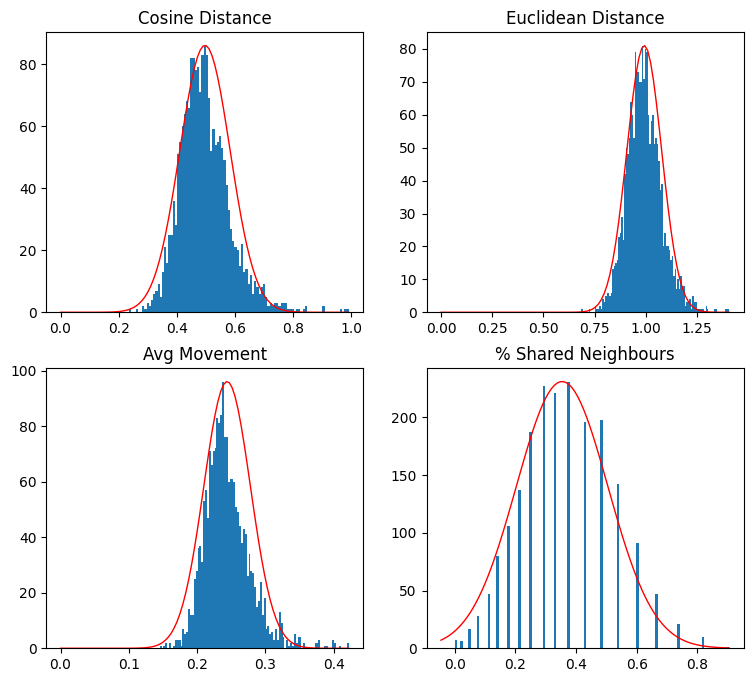

In [24]:
all_methods_metrics = all_methods_df[["Cosine Distance", "Euclidean Distance", "Avg Movement", "% Shared Neighbours"]]

all_methods_metrics.head()

fig, axes = plt.subplots(len(all_methods_metrics.columns)//2, 2, figsize=(9, 8))

sig_cutoff = {}

i = 0
for triaxis in axes:
    for ax in triaxis:
        method = all_methods_metrics.columns[i]
        data = all_methods_metrics[method]

        data_counts = data.value_counts(bins = 100)
        data_max = data_counts[data_counts.index[0]]

        histogram = ax.hist(data, bins = 100)

        mu, std = scipy.stats.norm.fit(data)
        xmin, xmax = plt.xlim()
        xmax = max(data)
        x = np.linspace(xmin, xmax, 100)
        p = scipy.stats.norm.pdf(x, mu, std)
        coeff = data_max/max(p)

        if "%" not in method:
            sig_cutoff[method] = scipy.stats.norm(mu, std).ppf(0.95)
        else:
            sig_cutoff[method] = scipy.stats.norm(mu, std).ppf(0.05)

        ax.plot(x, p*coeff, 'red', linewidth=1)
        ax.set_title(method)
        i = i+1

In [25]:
sig_cutoff

{'Cosine Distance': 0.6388904727418422,
 'Euclidean Distance': 1.1327294847232479,
 'Avg Movement': 0.30000655169725077,
 '% Shared Neighbours': 0.10566408978803174}

In [26]:
sig_words_in_all = {}

for method in sig_cutoff:

    data = all_methods_metrics[method]
    thres = sig_cutoff[method]

    if "%" not in method:
        significant_words = all_methods_metrics[all_methods_metrics[method] > thres].index
    else:
        significant_words = all_methods_metrics[all_methods_metrics[method] < thres].index

    print(set(significant_words))



{'interview', 'probability', 't', 'wilson', 'emphasis', 'credit', 'housing', 'budget', 'host', 'impact', 'network', 'block', 'programs', 'program', 'implications', 'magazine', 'philip', 'commonwealth', 'assessment', 'signal', 'holland', 'co', 'version', 'ml', 'gap', 'trend', 'goals', 'model', 'netherlands', 'van', 'plot', 'breast', 'ministry', 'background', 'shift', 'project', 'publications', 'jobs', 'reserve', 'mode', 'depression', 'bit', 'resolution', 'file', 'answers', 'wiley', 'input', 'counsel', 'macmillan', 'objectives', 'perspective', 'regime', 'evaluation', 'j', 'strain', 'survival', 'type', 'levels', 'focus', 'concerns', 'martin', 'agency', 'pattern', 'harper', 'post', 'jones', 'release', 'oxford', 'berkeley', 'currency', 'baltimore', 'sets', 'adjustment', 'therapy', 'models', 'patterns', 'sector', 'mcgraw', 'drive', 'channel', 'computer', 'row', 'personnel', 'stanford', 'film', 'attitudes', 'ray', 'grand', 'johnson', 'order', 'haven', 'economy', 'yale', 'projects', 'media', '

Of these results, the cosine distance metric stuck out to me as the best metric.

### Using Human-Annotated Data
The following dataset is from *Analysing Lexical Semantic Change with Contextualised Word Representations*, a 2021 paper by Giulianelli et. al. I attempted to correlate the biggest timesteps with my data to see which of my methods agreed most with the average human-annotated similarity measures.

In [27]:
human_similarity_annots = pd.read_csv(GDD + "aggregate.csv")

human_similarity_annots["Avg. Sim Score"] = human_similarity_annots.apply(lambda row:
                              mean([int(score) for score in row["sim_score"].split("\n")]),
                                                                          axis = 1)

human_similarity_annots["Year 1"] =  human_similarity_annots.apply(lambda row:
                                                                   int(row["time_a"][:4])
, axis = 1)
human_similarity_annots["Year 2"] =  human_similarity_annots.apply(lambda row:
                                                                   int(row["time_b"][:4])
, axis = 1)
human_similarity_annots.head()

valid_timeframe_subset = human_similarity_annots[(human_similarity_annots["Year 1"] == 1910) &
                        (human_similarity_annots["Year 2"] == 1990)]

valid_timeframe_subset_flat = valid_timeframe_subset.groupby(['lemma']).agg({'Avg. Sim Score': 'mean'}).reset_index()
valid_timeframe_subset_flat.head()

human_to_comp = valid_timeframe_subset_flat.set_index("lemma")

unified_data = all_methods_metrics.merge(human_to_comp, left_index=True, right_index=True)
unified_data.corr()

,Cosine Distance,Euclidean Distance,Avg Movement,% Shared Neighbours,Avg. Sim Score
Cosine Distance,1.000000,0.999030,0.667664,-0.956341,0.040120
Euclidean Distance,0.999030,1.000000,0.680470,-0.963655,0.082179
Avg Movement,0.667664,0.680470,1.000000,-0.667745,0.516171
% Shared Neighbours,-0.956341,-0.963655,-0.667745,1.000000,-0.201624
Avg. Sim Score,0.040120,0.082179,0.516171,-0.201624,1.000000


I was expecting the distance metrics to correlated strongly and negatively to the human notes and for the shared neighbours metric to correlate strongly and positively. I think because of the small size of the human-labeled data that I was not able to accurately capture the performance of the models. However, as cosine distance has the smallest correlation in the wrong direction, I will take that to be my best method.

## **Step 4** [3 points]
Extract the top 3 changing words using the best method from Steps 2 and 3. Propose and implement a simple way of detecting the point(s) of semantic change in each word based on its diachronic embedding time course -- visualize the time course and the detected change point(s).




In [31]:
## Visualization Code
def display_pca_scatterplot(embs, word, change_years):

    # Dataframe that will be used in scatterplot visualization.
    vis_df = pd.DataFrame(columns = ["Word", "x", "y", "Colour", "Alpha"])
    # Dataframe for vectors to be reduced via t-SNE and visualized.
    vis_word_vecs = pd.DataFrame(columns = [k for k in range(300)])

    plt.figure()
    nns = set()


    # Collect nearest neighbour words per decade for context.
    for year in change_years:
        year_nns = nearest_neighbours(year, word, n = 3)
        nns = nns.union(year_nns)

    context_words_to_visualize = list(nns)

    # Adding in the context word embeddings from 1990.
    for w in context_words_to_visualize:
        word_vec = df_by_year[1990].loc[w]
        vis_word_vecs.loc[w] = list(word_vec)

    # Adding in the word embeddings from each of the years.
    for year in change_years:
        word_vec = df_by_year[year].loc[word]
        vis_word_vecs.loc[word + "_" + str(year)] = list(word_vec)

    # Reducing vector dimensionality.
    tsne = TSNE(n_components=2, perplexity=2)
    words_twodim = tsne.fit_transform(vis_word_vecs)

    # Context word visualization.
    for w_i, w in enumerate(context_words_to_visualize):
        cl = "grey"
        al = 0.5

        vis_df.loc[len(vis_df)] = [w, words_twodim[w_i,0], words_twodim[w_i,1], 'gray', 0.5]

        plt.text(words_twodim[w_i,0],
                words_twodim[w_i,1],
                "${0}$".format(w, year),
                c=cl,
                alpha = al)


    # Target word diachronic visualization.
    for y_i, y in enumerate(change_years):
        cl = "k"
        al = 1

        cy_ind = (-len(change_years) + y_i)

        vis_df.loc[len(vis_df)] = [word, words_twodim[cy_ind,0], words_twodim[cy_ind,1], 'k', 1]

        plt.text(words_twodim[cy_ind,0],
                words_twodim[cy_ind,1],
                "${0}_{{{1}}}$".format(word, y),
                c=cl,
                alpha = al)


    plt.scatter(list(vis_df.x),
             list(vis_df.y),
             c = list(vis_df.Colour),
             alpha = list(vis_df.Alpha),
             s = 0.1)

    plt.title("Embedding for \'" + word + "\' Through Time")

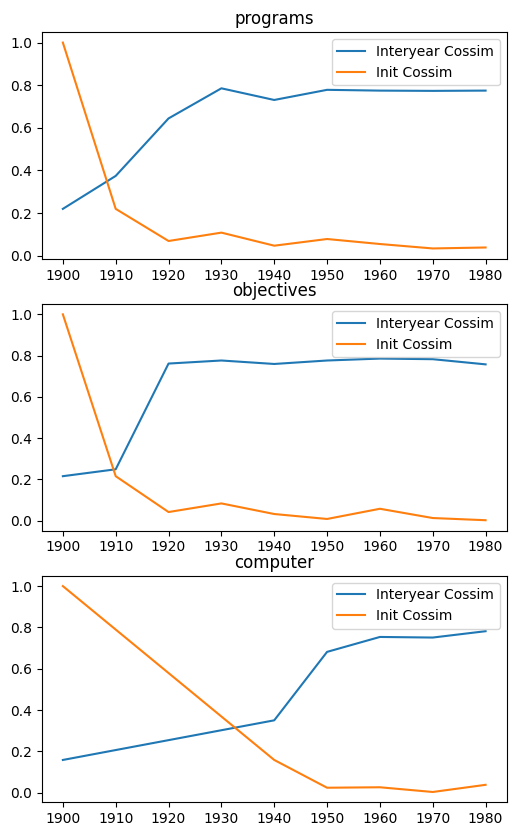

In [32]:
# To find the change years, plot the cosine similarity between the year's
# vector and the initial (1990) vector: Init Cossim. You can also plot the
# cosine similarity between years: Interyear Cossim to better see how the
# change moves from year to year.
# Change years are years when the Init Cossim change is drastic and away from
# the initial vector i.e. the init cossim drops significantly. I wanted to
# implement an automatic detection algorithm, but I ended up doing it manually.

word_list = list(method_1_df.sort_values(by=['Cosine Distance'], ascending = False).head(3)["Word"])

plt.figure(figsize = (6, 10))

for w_i, w_to_vis in enumerate(word_list):
    word_df = diachronic_df[diachronic_df["Word"] == w_to_vis]
    ini_vec = word_df.iloc[0]["Embedding"]

    disp_l = []
    cs_l = []
    yrs = []

    for i in range(len(word_df)-1):

        c_vec = word_df.iloc[i]["Embedding"]
        n_vec = word_df.iloc[i+1]["Embedding"]
        n_year = word_df.iloc[i+1]["Year"]
        c_year = word_df.iloc[i]["Year"]

        delta_vec = cosine_sim(c_vec, n_vec)
        disp = delta_vec
        cs = cosine_sim(c_vec, ini_vec)

        disp_l.append(disp)
        cs_l.append(cs)
        yrs.append(c_year)

    plt.subplot(3, 1, w_i + 1)
    plt.title(w_to_vis)
    plt.plot(yrs, disp_l, label = "Interyear Cossim")
    plt.plot(yrs, cs_l, label = "Init Cossim")
    plt.legend()


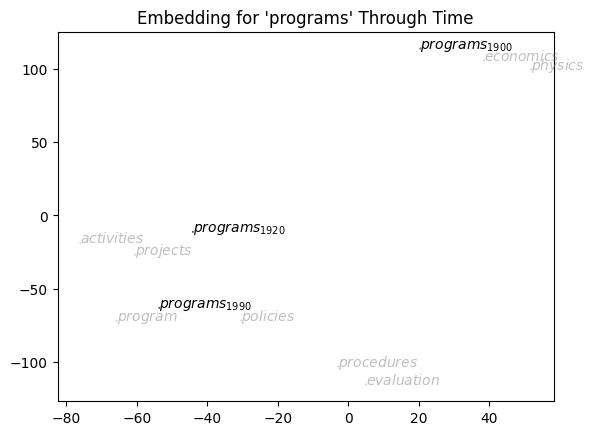

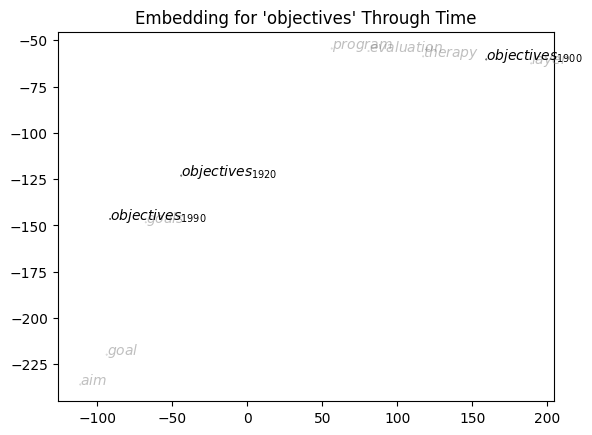

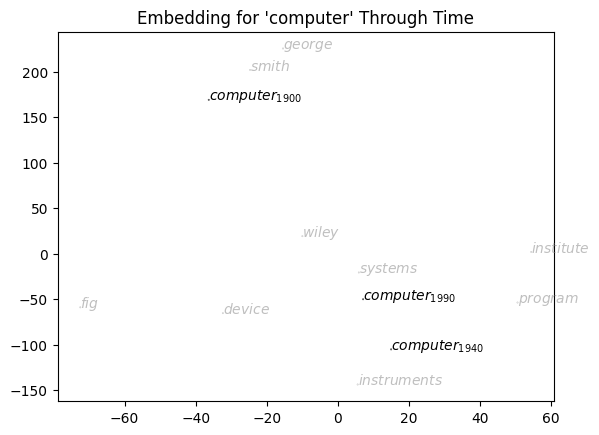

In [33]:
change_years_list = [[1900, 1920, 1990], [1900, 1920, 1990], [1900, 1940, 1990]]

for w_to_vis, cyl in zip(word_list, change_years_list):
    display_pca_scatterplot(diachronic_embeddings, w_to_vis, cyl)